# Time series clustering exercise

# Data

Download the census bureau business data for all years 1993-2014. You can investigate using the API (I have not done it with the census bureau). I did is as you see below

The data is on the github repo. Each file is the economic census for 1 year. 
Download it programmatically and move it to PUIdata

 Download the NYC zipcodes shapefile. One of many ways in which you can get the zipcodes shapefile for NYC
 https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip


## You can use zipfile module in python to unzip the files
it should be installed in your system, but if it is not you can get the code with wget from here
https://github.com/python/cpython/blob/2.7/Lib/zipfile.py
remembering to use the raw link
(or you can use the usual shell commands)

In [338]:
import pandas as pd
import zipfile 
import geopandas as gp
import os
import numpy as np
import pylab as pl
%pylab inline
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster as scp

Populating the interactive namespace from numpy and matplotlib


/nfshome/tc1767/.conda/envs/myEnv1/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [339]:
fname = []
for i in range(21):
    if i <= 5:
        fname.append('zbp' + '%d'%(i+94) + 'totals.zip')
    else:
        if i == 6:
            fname.append('zbp00totals.zip')
        else:
            if i<=15:
                fname.append('zbp0' + '%d'%(i-6) + 'totals.zip')
            else:
                fname.append('zbp' + '%d'%(i-6) + 'totals.zip')

In [340]:
df = []
for i in range(21):
    zf = zipfile.ZipFile(fname[i])
    df.append(pd.read_csv(zf.open(fname[i].replace('.zip','.txt'))))    

# Data cleaning

you may need to clean your data: for some NYC zip codes there may be no info
sanity check: you should have 20 (N_timestamps) datapoints per time series and about 250 zipcodes (Nzipcodes)


IMPORTANT: read the instructions below on pre-processing. Afte rthat:

mydata.shape should be (Nzipcodes, Ntimestamps)

mydata[i].std() shoould be 1 for all i in range(len(Nzipcodes))

mydata[i].mean() should be ~0 for all i in range(len(Nzipcodes))



## TASKS:
    
    1. get and prep your data.
    2. cluster the NUMBER OF ESTABLISHMENTS time series with K-means
    in **a few** clusters (as discussed there is no real good, sound way to 
    decide what a good number is here. try a few options, keeping in mind 
    a few is more than a couple, but i recommand you stay within the 
    single digit numbers)
    
    3. plot the cluster centers (if you used K means those are the means of 
    the clusters). you can plot for example the cluster centers overlayed on 
    each time series (using the alpha channel to control the opacity in the 
    plot may be helpful here).
    
    4. Use another clustering algorithm (of your choice)
    
    5. overlay your data on a NYC map: you can use shapefiles for the 
    zip codes and different colors for different clusters
    
    6. Compare the results of the 2 algorithms
    
    7. attempt an interpretation. this is dangerous ground: clustering is 
    an exploratory tool so you do not want to jump to conclusions because 
    you see some clusters! but seeing structure in your data can inform 
    your next moves as an investigator. 
    

Note on preprocessing: the preparation of these data should include the "standardization" of the time seris. 
*Always when you apply a moachine learning model you should standardize the data or whiten it.*
These operations may be complicated preprocessing operation, they can for example invoke PCA, and they are aimed at removing covariance in the feature space.

The simplest version of whitening *standardizes each feature*" from every column (feature) you subtract the mean and you divide it by the standard deviation.

But the time series preprocessing is different if you want to use each time stamp as feature: because you want to maintain the coherence of the data, i.e. you **do not want** to treat each feature as an independent feature! the pattenrs in the time series are what you are clustering on (time series goes up and down, creating a pattern) and those patterns would be lost by whitening.

*So when you cluster or otherwise use a time series in a model, using each timestamp as a feature, you want to standardize the observations, not the features.* 

**From each row of your table (observation, in this case each zipcode) subtract the mean and you divide the row by the standard deviation.**

In [341]:
if os.getenv("PUIDATA") is None:
    os.environ["PUIDATA"] = "%s/PUIdata"%os.getenv("HOME")
nyczipsshp = gp.read_file(os.getenv("PUIDATA") + "/ZIP_CODE_040114.shp")
#nyczipsshp.plot(figsize = (7,7))
#nyczipsshp.drop_duplicates("ZIPCODE").plot(figsize = (7,7))
#nyczipsshp
print("ZIPCODES:",
      len(np.unique(nyczipsshp.ZIPCODE)), "POLYGONS:",
      len(nyczipsshp.ZIPCODE),
      "the difference is due to island with same zip as parts of land,",
      "but disjoint shapes")
nyczips = nyczipsshp.ZIPCODE.values.astype(int)
print("number of NYC zip codes:", len(nyczips))

ZIPCODES: 248 POLYGONS: 263 the difference is due to island with same zip as parts of land, but disjoint shapes
number of NYC zip codes: 263


In [342]:
for i in range(21):
    try:
        df[i] = df[i].loc[df[i].zip.isin(nyczips)][['zip','est']]
    except:
        df[i] = df[i].rename(columns={'ZIP':'zip', 'EST':'est'})
        df[i] = df[i].loc[df[i].zip.isin(nyczips)][['zip','est']]

In [343]:
cbs = pd.DataFrame(np.sort(nyczips), columns=['zip'])
for i in range(21):
    cbs = cbs.merge(df[i], on='zip', how='outer')

In [344]:
cbs.index = cbs.zip.tolist()
cbs = cbs.drop(columns={'zip'})

In [345]:
new = []
for i in range(21):
    new.append(fname[i][3:5])
cbs.columns = new

In [346]:
cbs.shape

(263, 21)

In [347]:
cleancsb = cbs.dropna()
cleancsb.shape

(243, 21)

In [348]:
vals = (((cleancsb.T - cleancsb.mean(1)) / cleancsb.std(1)).T)
print(vals.shape)
vals.head()

(243, 21)


,94,95,96,97,98,99,00,01,02,03,...,05,06,07,08,09,10,11,12,13,14
10001,-1.839191,-1.193297,-1.287641,-0.714319,0.011404,-0.140998,0.468610,-0.467573,-0.808663,-1.222326,...,0.432324,1.179819,2.152288,1.593481,0.381523,-0.082940,-0.184541,-0.126483,0.149292,0.845986
10002,-1.713540,-1.626405,-1.377447,-1.053802,-1.168323,-0.964178,-0.486179,0.176049,-0.506095,-0.174982,...,0.522100,0.532058,0.529569,0.544506,0.753631,0.995120,1.094703,1.199265,1.283911,1.244077
10003,-1.820497,-1.434653,-1.307101,-0.930824,-0.567301,-0.535414,-0.458882,-0.717175,-0.672532,-0.391918,...,0.127855,0.261785,0.708216,0.778369,0.867655,0.912298,1.058983,1.234367,1.435260,1.613833
10004,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,-0.379639,...,-0.313478,0.108300,0.596238,0.645859,0.670669,0.827802,0.877423,1.191688,1.497684,2.117945
10004,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,-0.379639,...,-0.313478,0.108300,0.596238,0.645859,0.670669,0.827802,0.877423,1.191688,1.497684,2.117945


In [349]:
nyczipsshp = nyczipsshp.sort_values(by='ZIPCODE')
nyczipsshp.shape

(263, 13)

In [350]:
#vals_ is a dataframe dropping dupilcate zipcode and with column 'zip'
vals_ = vals
vals_['zip'] = vals_.index
vals_ = vals_.drop_duplicates('zip')
print(vals_.shape)

(230, 22)


In [351]:
nyczipsshp = nyczipsshp.merge(vals_, left_on=nyczipsshp.ZIPCODE.astype(int), right_on=vals_.index)
print(nyczipsshp.shape)

(243, 36)


In [352]:
nyczipsshp.iloc[:,14:35].head()

,94,95,96,97,98,99,00,01,02,03,...,05,06,07,08,09,10,11,12,13,14
0,-1.839191,-1.193297,-1.287641,-0.714319,0.011404,-0.140998,0.468610,-0.467573,-0.808663,-1.222326,...,0.432324,1.179819,2.152288,1.593481,0.381523,-0.082940,-0.184541,-0.126483,0.149292,0.845986
1,-1.713540,-1.626405,-1.377447,-1.053802,-1.168323,-0.964178,-0.486179,0.176049,-0.506095,-0.174982,...,0.522100,0.532058,0.529569,0.544506,0.753631,0.995120,1.094703,1.199265,1.283911,1.244077
2,-1.820497,-1.434653,-1.307101,-0.930824,-0.567301,-0.535414,-0.458882,-0.717175,-0.672532,-0.391918,...,0.127855,0.261785,0.708216,0.778369,0.867655,0.912298,1.058983,1.234367,1.435260,1.613833
3,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,-0.379639,...,-0.313478,0.108300,0.596238,0.645859,0.670669,0.827802,0.877423,1.191688,1.497684,2.117945
4,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,-0.379639,...,-0.313478,0.108300,0.596238,0.645859,0.670669,0.827802,0.877423,1.191688,1.497684,2.117945


# Use K-Means Clustering

## 5 k-means clusters

In [353]:
#cluster with kmeans
km5 = KMeans(n_clusters=5, random_state=444).fit(nyczipsshp.iloc[:,14:35])
labelskm5= km5.labels_
centerkm5 = km5.cluster_centers_
nyczipsshp['km5pred'] = km5.predict(nyczipsshp.iloc[:,14:35])

In [354]:
centerkm5 = pd.DataFrame(centerkm5)
centerkm5.columns = new
centerkm5

,94,95,96,97,98,99,00,01,02,03,...,05,06,07,08,09,10,11,12,13,14
0,-1.897212,-1.579830,-1.316381,-0.947555,-0.795462,-0.593882,-0.433361,-0.426284,-0.065457,0.147641,...,0.552038,0.618081,0.680251,0.651834,0.629088,0.693993,0.777095,0.800952,0.939552,1.131277
1,0.453372,0.813541,0.807136,0.930850,0.994968,1.025998,1.109030,0.782202,0.017503,-0.086176,...,-0.142502,-0.084347,-0.408615,-0.501522,-0.567447,-0.766522,-0.950039,-1.096309,-1.126554,-1.126624
2,-1.049839,-0.934987,-0.535036,-0.177836,0.011408,0.031438,0.530783,0.718453,0.746627,0.785770,...,0.658019,0.351410,0.068618,-0.253287,-0.521265,-0.590875,-0.865985,-0.316851,-0.026746,0.051446
3,-1.261151,-1.209763,-1.120511,-0.998020,-0.902588,-0.873517,-0.756670,-0.660690,-0.324023,-0.195824,...,0.084305,0.132629,0.350511,0.496028,0.630690,0.897549,1.069446,1.299702,1.575983,1.806066
4,1.238077,0.692357,0.149984,-0.310377,-0.519848,-0.005951,-0.438179,-0.520041,-0.790538,-0.917215,...,-0.329040,-0.386288,-0.117286,-0.171795,-0.002486,0.064544,0.238955,0.715385,0.788412,1.134061


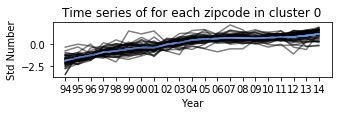

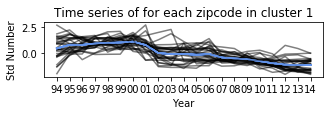

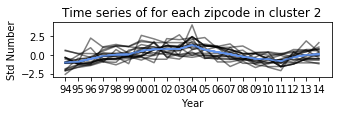

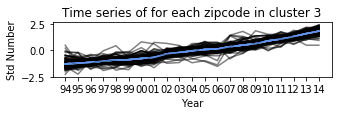

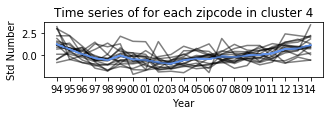

In [373]:
for i in range(5):
    f, ax = plt.subplots(figsize=(5,1))
    ax.set_title("Time series of for each zipcode in cluster %d"%i)
    ax.set_xlabel("Year")
    ax.set_ylabel("Std Number")
    for j in range(nyczipsshp[nyczipsshp['km5pred'] == i].iloc[:,14:35].shape[0]):
        ax.plot(nyczipsshp[nyczipsshp['km5pred'] == i].iloc[:,14:35].iloc[j], c='black', alpha=0.5)
        ax.plot(centerkm5.iloc[i], c='#6495ED', alpha=0.5)

#### Figure1: Time series plots of standardized number of establishment of new businesses in each zipcode in NYC from year 1994 to year 2014 for each cluster.  Each cluster is generated using k-means clusting method in 5 clusters. Cluster 0 and cluster 3 have significant trend of increasing in number while cluster 1 has significant trend of decreasing. Cluster 2 and cluster 4 oscillate over 21 years.

Text(0.5,1,'K-means 5 Clusters by zipcode')

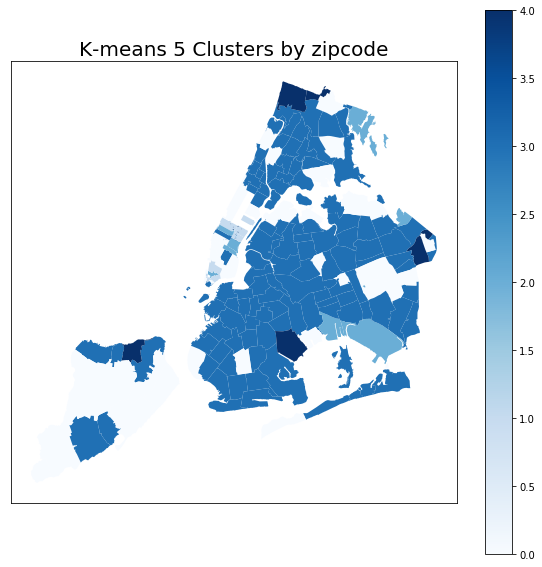

In [356]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
nyczipsshp.plot(column = 'km5pred', cmap='Blues', ax=ax, legend=True)
ax.set_title("K-means 5 Clusters by zipcode", fontsize=20)

#### Figure 2: Choropleth map of cluster centers of number of establishment of new businesses in each zipcode in NYC. Each cluster is generated by k-means clustering method using 5 clusters and each color indicates a cluster.

## 7 k-means clusters

In [357]:
km7 = KMeans(n_clusters=7, random_state=444).fit(nyczipsshp.iloc[:,14:35])
centerkm7 = km7.cluster_centers_
labelskm7= km7.labels_
nyczipsshp['km7pred'] = km7.predict(nyczipsshp.iloc[:,14:35])

In [358]:
centerkm7 = pd.DataFrame(centerkm7)
centerkm7.columns = new
centerkm7

,94,95,96,97,98,99,00,01,02,03,...,05,06,07,08,09,10,11,12,13,14
0,-1.261151,-1.209763,-1.120511,-0.998020,-0.902588,-0.873517,-0.756670,-0.660690,-0.324023,-0.195824,...,0.084305,0.132629,0.350511,0.496028,0.630690,0.897549,1.069446,1.299702,1.575983,1.806066
1,-0.335430,0.130116,0.553634,0.760233,1.024704,1.056509,1.115004,0.901868,0.430184,0.497722,...,0.367620,0.378624,-0.209468,-0.397842,-0.515915,-0.922231,-1.144468,-1.324223,-1.357917,-1.364940
2,-1.941790,-1.604427,-1.346418,-0.953492,-0.779361,-0.617893,-0.452961,-0.447978,-0.065154,0.150099,...,0.552911,0.639862,0.688618,0.663565,0.644049,0.706838,0.793454,0.840899,0.955757,1.148401
3,-1.050787,-0.844461,-0.445458,0.177094,0.457950,0.881996,1.645066,1.720278,0.035841,-0.417452,...,-0.407452,-0.502204,-0.523012,-0.534827,-0.569562,-0.412244,-0.268776,0.292047,0.539893,0.262347
4,1.270023,0.745149,0.125541,-0.267476,-0.566125,-0.221075,-0.600404,-0.592037,-0.980031,-0.954768,...,-0.276331,-0.202409,-0.235302,-0.192804,0.047224,0.136551,0.363451,0.811017,0.841956,1.264803
5,-0.871059,-0.796999,-0.686688,-0.493944,-0.421575,-0.227526,0.105719,0.388651,0.785703,1.020665,...,0.942794,0.588469,0.253201,-0.030967,-0.415747,-0.505501,-0.855909,-0.541824,-0.151101,0.113482
6,1.283418,1.371438,1.178992,1.016007,0.907569,0.964815,0.898922,0.318881,-0.188704,-0.554808,...,-0.565610,-0.646746,-0.332552,-0.551931,-0.564565,-0.612610,-0.841340,-0.823689,-0.835619,-0.855730


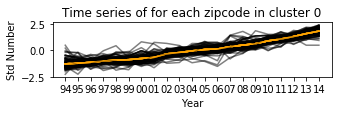

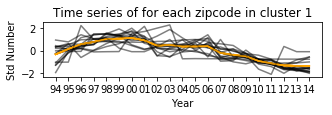

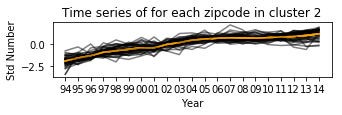

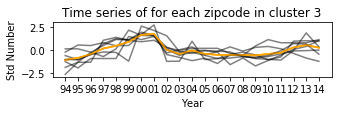

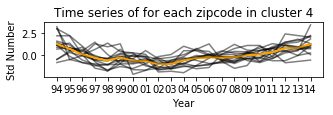

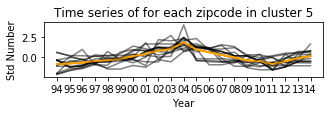

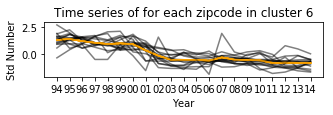

In [375]:
for i in range(7):
    f, ax = plt.subplots(figsize=(5,1))
    ax.set_title("Time series of for each zipcode in cluster %d"%i)
    ax.set_xlabel("Year")
    ax.set_ylabel("Std Number")
    for j in range(nyczipsshp[nyczipsshp['km7pred'] == i].iloc[:,14:35].shape[0]):
        ax.plot(nyczipsshp[nyczipsshp['km7pred'] == i].iloc[:,14:35].iloc[j], c='black', alpha=0.5)
        ax.plot(centerkm7.iloc[i], c='Orange', alpha=0.5)

#### Figure3: Time series plots of standardized number of establishment of new businesses in each zipcode in NYC from year 1994 to year 2014 for each cluster.  Each cluster is generated using k-means clusting method in 7 clusters. Cluster 0 and cluster 2 have significant trend of increasing in number while cluster 1 and cluster 6 have significant trend of decreasing. Cluster 3, cluster 4 and cluster 5 oscillate over 21 years.

Text(0.5,1,'K-means 7 clusters by zipcode')

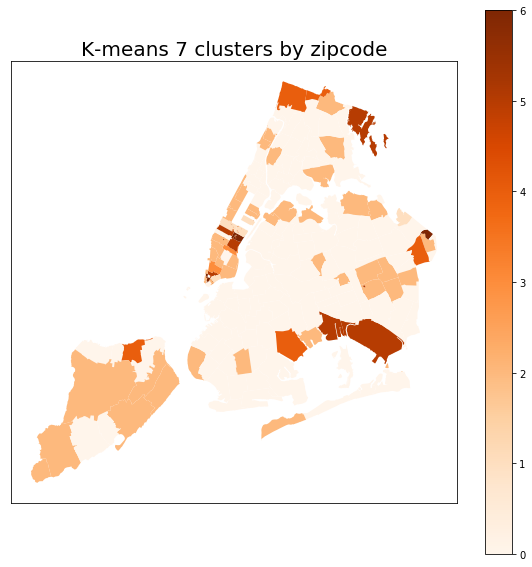

In [360]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
nyczipsshp.plot(column = 'km7pred', cmap='Oranges', ax=ax, legend=True)
ax.set_title("K-means 7 clusters by zipcode", fontsize=20)

#### Figure 4: Choropleth map of cluster centers of number of establishment of new businesses in each zipcode in NYC. Each cluster is generated by k-means clustering method using 5 clusters and each color indicates a cluster.

# Use agglomerative clustering

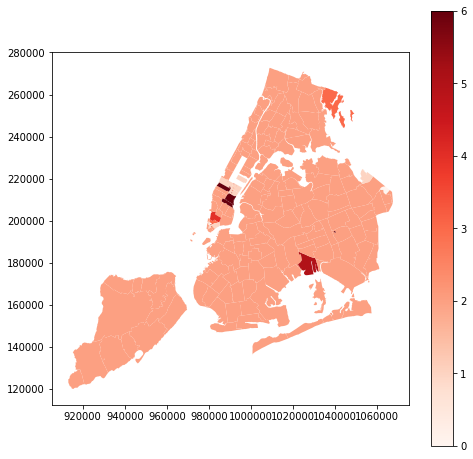

In [379]:
agc = AgglomerativeClustering(n_clusters=7, linkage='average')
nyczipsshp['agcpred'] = agc.fit_predict(nyczipsshp.iloc[:,14:35])
f, ax = plt.subplots(figsize=(8,8))
nyczipsshp.plot(column = 'agcpred', cmap='Reds', ax=ax, legend=True)


#### Figure 5: Choropleth map of cluster centers of number of establishment of new businesses in each zipcode in NYC. Each cluster is generated by agglomerative clustering method using 7 clusters and each color indicates a cluster.

# Use hierarchical clustering

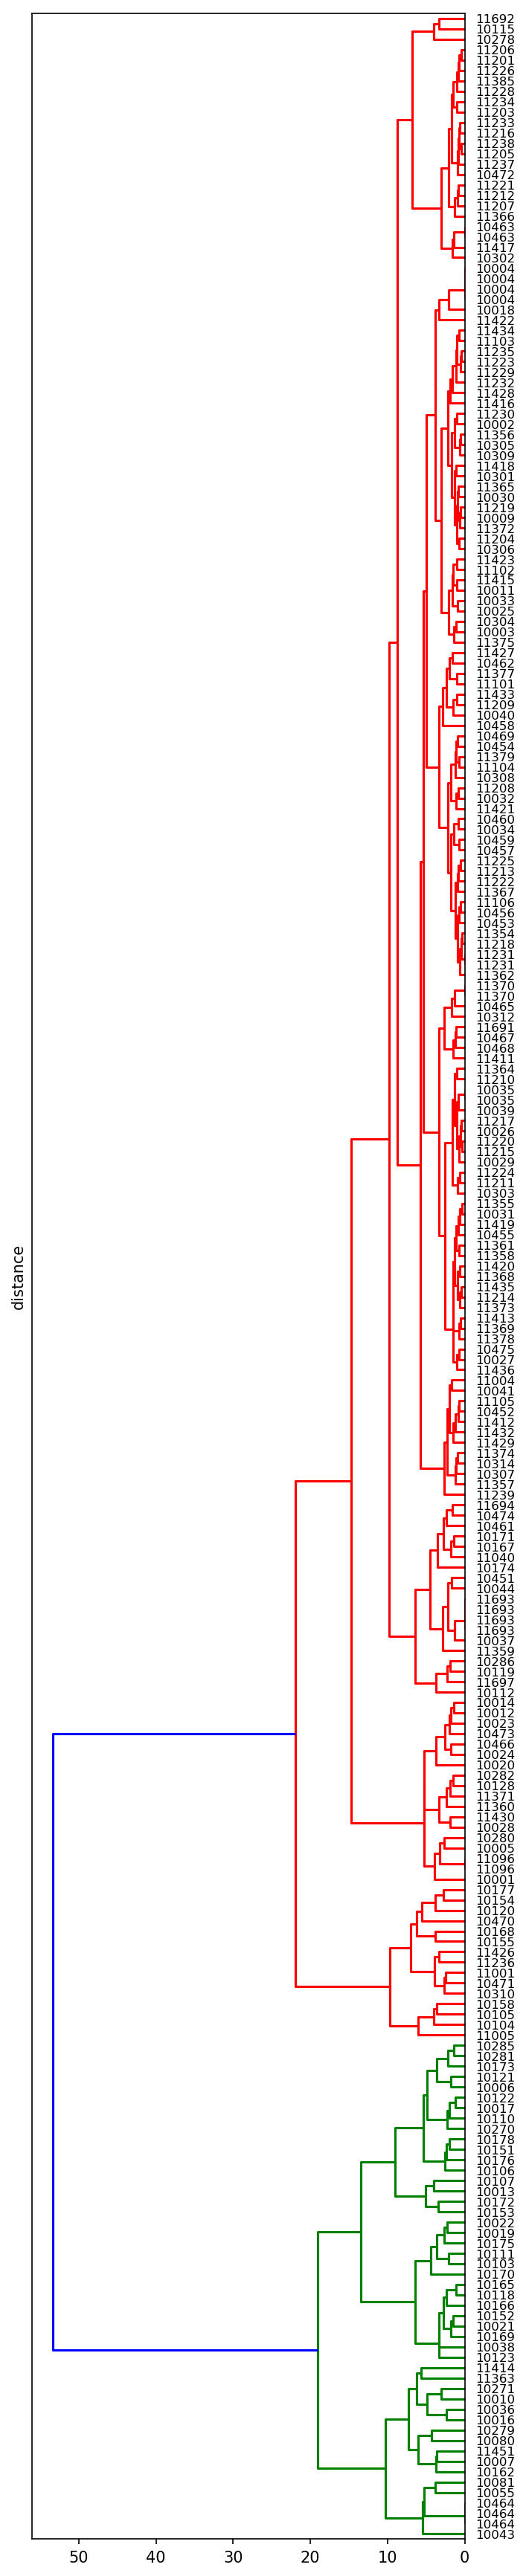

In [363]:
fig = pl.figure(figsize=(5,30), dpi=150)
pl.ylabel("distance")
ddg = scp.hierarchy.dendrogram(scp.hierarchy.linkage(nyczipsshp.iloc[:,14:35], method='ward'),
                               labels = np.array(nyczipsshp.ZIPCODE),
                               orientation='left',# rotates the x axis labels
                               leaf_font_size=8.)  # font size for the x axis labels)

#### Figure6: Hierarchical clustering of number of establishment of new businesses in each zipcode in NYC.
